In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import seaborn as sns

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from sklearn.impute import SimpleImputer

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance


from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


In [2]:
all_data= pd.read_csv(r"C:\Users\Jiayi\OneDrive - ucsc.edu\python\project\housing_kaggle\train_cleaned.csv")
X=all_data.drop(["SalePrice","Id","Unnamed: 0"],axis=1).reset_index(drop=True, inplace=False)
y= (all_data.SalePrice[all_data.SalePrice>0].reset_index(drop=True, inplace=False))


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

### Linear Regressions

In [4]:
#Feature Selection
lr_model = LinearRegression()
rfecv = RFECV(estimator=lr_model, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)
print('The optimal number of features is {}'.format(rfecv.n_features_))
features = [f for f,s in zip(X_train.columns, rfecv.support_) if s]


The optimal number of features is 141


Text(0, 0.5, 'Predicted Sold-price')

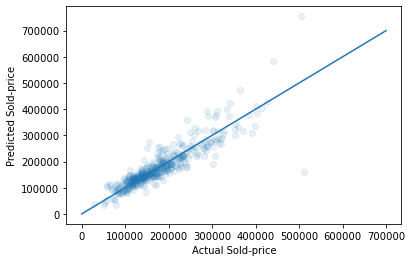

In [5]:
lr_model.fit(X_train.loc[:,features],y_train)
# check predictions with test dataset
test_set_pred = lr_model.predict(X_test.loc[:,features])
plt.scatter(test_set_pred,y_test,alpha=.1)
plt.plot(np.linspace(0,700000,1000),np.linspace(0,700000,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Predicted Sold-price')

Text(0, 0.5, 'Residuals')

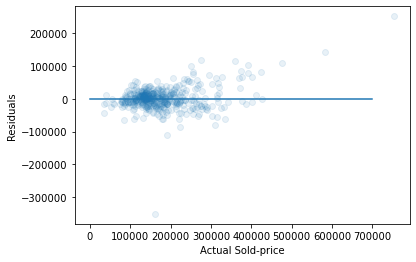

In [6]:
#check residuals
plt.scatter(y_test, y_test-test_set_pred,alpha=.1)
plt.plot(np.linspace(0,700000,1000),np.linspace(0,0,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Residuals')

In [9]:
#R-square
lr_score=lr_model.score(X_test.loc[:,features],y_test)
print(lr_score)
#RMSE
lr_rmse=np.sqrt(np.mean((test_set_pred - y_test)**2))
print(lr_rmse)

0.7887190290447281
36463.07456925627


### Lasso Regressions

In [10]:
#Feature Selection
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
ls_model = Lasso(random_state = 0)
ls_rfecv = RFECV(estimator=ls_model, step=1, cv=5, scoring='neg_mean_squared_error')
ls_rfecv.fit(X_train, y_train)
print('The optimal number of features is {}'.format(ls_rfecv.n_features_))
features_ls = [f for f,s in zip(X_train.columns, ls_rfecv.support_) if s]


The optimal number of features is 138


In [12]:
#Hyperparameter Tuning-GridSearch CV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.0003, 0.0007, 0.0005, 0.05, 0.5, 1.0],
    'selection': ['random', 'cyclic'],
    'tol':[2e-03, 0.003, 0.001, 0.0005],
    'max_iter': [5]
}

ls_model_cv= GridSearchCV(estimator=ls_model, param_grid=param_grid, cv= 5)
ls_model_cv.fit(X_train.loc[:,features_ls],y_train)
ls_model_cv.best_params_

{'alpha': 1.0, 'max_iter': 5, 'selection': 'random', 'tol': 0.002}

In [13]:
ls_model1=Lasso(random_state =0,alpha=1.0,max_iter=5,selection="random",tol=0.002)
ls_model1.fit(X_train.loc[:,features_ls],y_train)

Lasso(max_iter=5, random_state=0, selection='random', tol=0.002)

Text(0, 0.5, 'Predicted Sold-price')

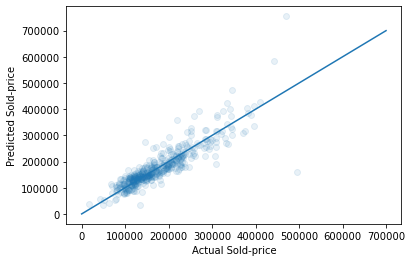

In [14]:
# check predictions with test dataset
test_set_pred = ls_model1.predict(X_test.loc[:,features_ls])
plt.scatter(test_set_pred,y_test,alpha=.1)
plt.plot(np.linspace(0,700000,1000),np.linspace(0,700000,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Predicted Sold-price')

Text(0, 0.5, 'Residuals')

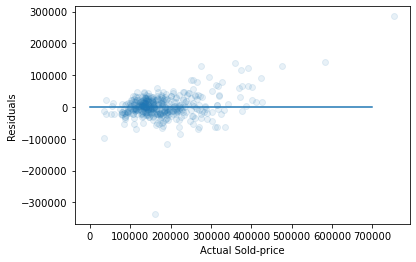

In [15]:
#check residuals
plt.scatter(y_test, y_test-test_set_pred,alpha=.1)
plt.plot(np.linspace(0,700000,1000),np.linspace(0,0,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Residuals')

In [16]:
ls_score=ls_model1.score(X_test.loc[:,features_ls],y_test)
print(ls_score)
#RMSE
ls_rmse=np.sqrt(np.mean((test_set_pred - y_test)**2))
print(ls_rmse)

0.769470770178067
38087.81800304933


### Random Forest

In [17]:
#Feature Selection
rf_model = RandomForestRegressor(random_state = 101)
rfecv = RFECV(estimator=rf_model, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)
print('The optimal number of features is {}'.format(rfecv.n_features_))
features_rf = [f for f,s in zip(X_train.columns, rfecv.support_) if s]


The optimal number of features is 101


In [ ]:
#Hyperparameter Tuning-GridSearch CV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 200, 300,600]
}

rf_model_cv= GridSearchCV(estimator=rf_model, param_grid=param_grid, cv= 5)
rf_model_cv.fit(X_train.loc[:,features_rf],y_train)
rf_model_cv.best_params_

In [ ]:
rf_model1=RandomForestRegressor(random_state = 101,max_features='auto', n_estimators= 300, max_depth=8, min_samples_leaf=2,min_samples_split=10)
rf_model1.fit(X_train.loc[:,features_rf],y_train)

In [ ]:
# check predictions with test dataset
test_set_pred = rf_model1.predict(X_test.loc[:,features_rf])
plt.scatter(test_set_pred,y_test,alpha=.1)
plt.plot(np.linspace(0,700000,1000),np.linspace(0,700000,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Predicted Sold-price')

In [ ]:
#check residuals
plt.scatter(y_test, y_test-test_set_pred,alpha=.1)
plt.plot(np.linspace(0,700000,1000),np.linspace(0,0,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Residuals')

In [ ]:
rf_score=rf_model1.score(X_test.loc[:,features_rf],y_test)
print(rf_score)
#RMSE
rf_rmse=np.sqrt(np.mean((test_set_pred - y_test)**2))
print(rf_rmse)

### Gradient Boosting

In [ ]:
#Feature Selection
gb_model = GradientBoostingRegressor(random_state=101)
gb_rfecv = RFECV(estimator=gb_model, step=1, cv=5, scoring='neg_mean_squared_error')
gb_rfecv.fit(X_train, y_train)
print('The optimal number of features is {}'.format(gb_rfecv.n_features_))
features_gb = [f for f,s in zip(X_train.columns, gb_rfecv.support_) if s]


In [ ]:
#Hyperparameter Tuning-GridSearch CV
from sklearn.model_selection import GridSearchCV
gb_param_grid = {
    'max_depth': [2,3],
    'min_samples_leaf': [1,2],
    'learning_rate': np.arange(0.01,0.1,0.01),
    'n_estimators': [50, 100, 200, 300,600]
}

gb_model_cv= GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv= 5)
gb_model_cv.fit(X_train.loc[:,features_gb],y_train)
gb_model_cv.best_params_

In [ ]:
gb_model1=GradientBoostingRegressor(random_state = 101,n_estimators= 300, max_depth=2, min_samples_leaf=2,learning_rate=0.09)
gb_model1.fit(X_train.loc[:,features_gb],y_train)

In [ ]:
# check predictions with test dataset
test_set_pred = gb_model1.predict(X_test.loc[:,features_gb])
plt.scatter(test_set_pred,y_test,alpha=.1)
plt.plot(np.linspace(0,700000,1000),np.linspace(0,700000,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Predicted Sold-price')

In [ ]:
#check residuals
plt.scatter(y_test, y_test-test_set_pred,alpha=.1)
plt.plot(np.linspace(0,700000,1000),np.linspace(0,0,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Residuals')

In [ ]:
gb_score=gb_model1.score(X_test.loc[:,features_gb],y_test)
print(gb_score)

#RMSE
gb_rmse=np.sqrt(np.mean((test_set_pred - y_test)**2))
print(gb_rmse)

In [ ]:
model={"Model":["Linear Regression","Lasso Regression", "Random Forest","Gradient Boosting"], "R-square":[lr_score,ls_score,rf_score,gb_score],"RMSE":[lr_rmse,ls_rmse,rf_score,gb_rmse]}
pd.DataFrame.from_dict(model)

In [11]:
#dset = pd.DataFrame()
#dset['attr'] = features
#dset['importance'] = rfecv.estimator_.feature_importances_
#dset = dset.sort_values(by='importance', ascending=False)
#display(dset.head(20))
#plt.figure(figsize=(16, 14))
#plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
#plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
#plt.xlabel('Importance', fontsize=14, labelpad=20)
#plt.yticks(fontsize=20)
#plt.xticks(fontsize=20)
#plt.show()

In [25]:
#plt.figure()
#plt.xlabel("Number of features selected")
#plt.ylabel("Cross validation score (neg_mean_squared_error)")
#plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)